# 공지사항

## 3. 모델링 및 모델해석 (1 Day)
- 기준모델baseline model 선정, 모델링 성능 평가
- 반복적인 Feature Engineering을 통해 모델 성능 최적화
- 문제 정의에 맞는 평가지표 선택, 모델 성능 설명
- 교차검증이나 hold-out 기법을 사용해 학습 성능/일반화 성능 구분하여 제시
- 여러 수치적 지표 및 permutation importance, pdp, shap 등을 활용해 최종모델 설명 (시각화는 설명이 가장 중요)
- 1.에서 제시한 가설 해결

Q1. 학습한 모델이 기준모델보다 성능이 잘 나왔나? 그렇지 않다면 이유는?<br>
Q2. 모델 성능 개선을 위해 어떤 방법을 적용했나? 그 방법을 선택한 이유는?<br>
Q3. 최종 모델과 일반화 성능에 관해 설명<br>
Q4. 모델이 관측치를 예측하기 위해 어떤 특성을 활용했나?

## 4. 발표자료 준비 및 제출 (0.5 Day)
- 프로젝트 결과를 정리하여 발표자료 제작
- 청자는 비데이터 직군 가정 
- 설정한 가설의 해소 과정(본인의 프로젝트 논리 전개 과정)을 꼼꼼히 담아보기
- 본인의 프로젝트 회고 + 보완할 점 제시

# Load train data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
filename = '/content/train1.csv'

In [3]:
import pandas as pd
data = pd.read_csv(filename)
data = data.drop(axis = 1, columns = ['Unnamed: 0'])
print(data.shape) # (5410, 39)

(5410, 39)


In [4]:
data.head(2)

,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,Duration_IP,Claim_Period,Claimed_extra,Inpatient_or_Outpatient,RenalDiseaseIndicator,NoOfMonths_PartACov,...,PerProvider_mean_Patient_Risk_Score,PerProvider_count_ClaimID,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5,PerProvider_count_Claims,Age_average
0,PRV51001,No,104640,5340.0,30.0,30.0,0.0,5,8,300,...,0.009408,0.040000,9.0,16.0,21.0,4.0,0.0,0.0,25,79.0
1,PRV51003,Yes,605670,66286.0,382.0,382.0,0.0,62,29,1560,...,0.000273,0.007576,54.0,78.0,107.0,24.0,0.0,1.0,132,70.0


타겟 라벨 변환 ('Yes': 1 / 'No': 0)

In [5]:
data.PotentialFraud.replace(['Yes', 'No'], ['1', '0'], inplace = True)
data.PotentialFraud = data.PotentialFraud.astype('int64')

Train/Test split (80/20)

In [6]:
from sklearn.model_selection import train_test_split
target = 'PotentialFraud'
train, test = train_test_split(data, test_size = 0.2, stratify = data[target])
print(train.shape, test.shape) # (4328, 245) (1082, 245) > (4328, 39) (1082, 39)

(4328, 39) (1082, 39)


# 기준모델baseline model 선정, 모델링 성능 평가

In [7]:
# 0 = No, 1 = Yes
target = 'PotentialFraud'

In [8]:
# 타겟 데이터 범주의 비율 확인
y_train = train[target]
y_train.value_counts(normalize = True) # 불균형 클래스

0    0.906423
1    0.093577
Name: PotentialFraud, dtype: float64

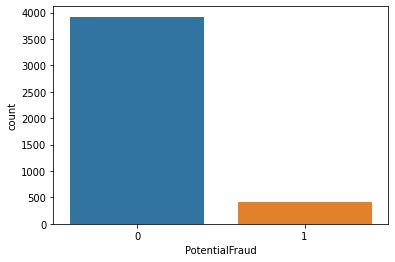

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x = y_train)

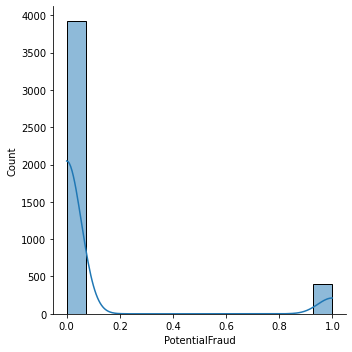

In [10]:
sns.displot(y_train, kde = True)

In [11]:
major = y_train.mode()[0]
y_pred = [major] * len(y_train)

In [12]:
# 기준모델의 성능 평가 (정확도 accuracy)
from sklearn.metrics import accuracy_score
print("기준모델 학습 정확도: ", accuracy_score(y_train, y_pred)) # 최다 클래스의 빈도 = 정확도

# 기준모델 학습 정확도:  0.9064232902033271 (약 90.6%)

기준모델 학습 정확도:  0.9064232902033271


In [13]:
# 검증 세트에서의 정확도
train, val = train_test_split(train, test_size = 0.2, stratify = train[target])
print(train.shape, val.shape) # (3462, 245) (866, 245) > (3462, 39) (866, 39)

(3462, 39) (866, 39)


In [14]:
y_val = val[target]
major1 = y_val.mode()[0]
y_pred_val = [major1] * len(y_val)
print("기준모델 검증 정확도: ", accuracy_score(y_val, y_pred_val))

# 기준모델 검증 정확도:  0.9066543438077634 (약 90.6%)

기준모델 검증 정확도:  0.9064665127020786


## X, y

In [15]:
# target = 'PotentialFraud'
features = train.drop(columns = [target, 'Provider']).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
# y_test = test[target]

print("X_train: ", X_train.shape) # (3462, 243)
print("y_train: ", y_train.shape) # (3462,)
print("X_val: ", X_val.shape) # (866, 243)
print("y_val: ", y_val.shape) # (1082, )
print("X_test: ", X_test.shape) # (1082, 243)
# print("y_test: ", y_test.shape) # 

X_train:  (3462, 37)
y_train:  (3462,)
X_val:  (866, 37)
y_val:  (866,)
X_test:  (1082, 37)


## Standardize train/test data

In [16]:
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
standardscaler.fit(X_train)
X_train_std = standardscaler.transform(X_train)
X_val_std = standardscaler.transform(X_val)
X_test_std = standardscaler.transform(X_test)

## Oversampling with SMOTE fit_resample()

In [17]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 9.0 MB/s 
     |████████████████████████████████| 199 kB 56.7 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ", X_train.shape, y_train.shape)
print("SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ", X_train_over.shape, y_train_over.shape)
print("SMOTE 적용 후 레이블 값의 분포 :\n", pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (3462, 37) (3462,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (6276, 37) (6276,)
SMOTE 적용 후 레이블 값의 분포 :
 0    3138
1    3138
Name: PotentialFraud, dtype: int64


**SMOTE 전 클래스 확인**

In [19]:
from collections import Counter
counter1 = Counter(y_train)
print(counter1)

Counter({0: 3138, 1: 324})


In [20]:
non_fraud = counter1[0]/(counter1[0]+counter1[1])
fraud = counter1[1]/(counter1[0]+counter1[1])
# {.2f}%.format()
print("Non-fraud % : {:.2f}%".format(non_fraud*100))
print("Fraud % : {:.2f}%".format(fraud*100))

Non-fraud % : 90.64%
Fraud % : 9.36%


Text(0.5, 1.0, 'Class (befoer SMOTE)')

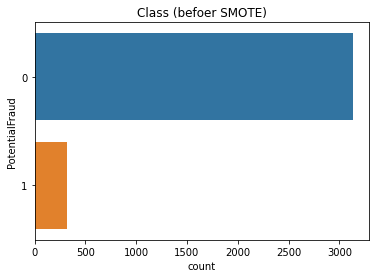

In [21]:
import seaborn as sns
sns.countplot(y=y_train)
plt.title('Class (befoer SMOTE)')

**SMOTE 후 클래스 확인**

In [22]:
counter2 = Counter(y_train_over)
print(counter2)

Counter({0: 3138, 1: 3138})


In [23]:
non_fraud = counter2[0]/(counter2[0]+counter1[1])
fraud = counter2[1]/(counter2[0]+counter1[1])

print("Non-fraud % : {:.2f}%".format(non_fraud*100))
print("Fraud % : {:.2f}%".format(fraud*100))

Non-fraud % : 90.64%
Fraud % : 90.64%


Text(0.5, 1.0, 'Class (after SMOTE)')

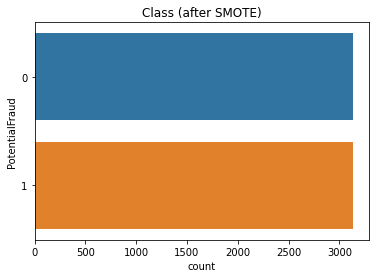

In [24]:
sns.countplot(y=y_train_over)
plt.title('Class (after SMOTE)')

# Modelling

## 모델 구축<br>
1. LogisticRegression <br>
2. DecisionTreeClassifier <br>
3. RandomForestClassifier <br>
4. XGBClassifier <br>
5. AdaBoost

In [25]:
# 분류 모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 앙상블 모델
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
# from sklearn import svm
# from sklearn.svm import SVC, LinearSVC

# 모델 검정
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

from scipy.stats import randint, uniform

# 검정결과 시각화
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 최적화
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import cross_val_score # 교차타당도

In [26]:
logistic_r = LogisticRegression(
    solver = 'liblinear', 
    penalty = 'l2', 
    C = 1.0, 
    random_state = 42
    )

decision_tree = DecisionTreeClassifier(
    criterion = 'entropy', 
    # maX_features = 1,
    min_samples_leaf = 1,
    random_state = 42
    ) 

randomforestclf = RandomForestClassifier(
    criterion = 'gini', 
    n_estimators = 100, 
    random_state = 42
    )

xgboost = XGBClassifier(
    learning_rate = 1,
    max_depth = 10, 
    n_estimators = 100, 
    random_state = 42
    )

adaboost = AdaBoostClassifier(
    base_estimator = decision_tree,
    n_estimators = 200, 
    learning_rate = 0.1, 
    random_state = 42
    )

## 모델 검증: 1) cross_val_score 2) ROC curve
- 반복적인 Feature Engineering을 통해 모델 성능 최적화
- 문제 정의에 맞는 평가지표 선택, 모델 성능 설명 (confusion_matrix, f1_score, roc/auc, classification_report)

### **LogisticRegression, DecisionTreeClassifier**

In [27]:
models = [logistic_r, decision_tree]
labels = ['Logistic Regression', 'DecisionTreeClassifier']

for model, label in zip(models, labels):
    scores = cross_val_score(
        estimator = model, 
        X = X_train_over, y = y_train_over, 
        cv = 10, 
        scoring = 'roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]" %(scores.mean(), scores.std(), label))

# ROC AUC: 0.933 (+/- 0.012) [Logistic Regression]
# ROC AUC: 0.925 (+/- 0.028) [DecisionTreeClassifier]

ROC AUC: 0.928 (+/- 0.012) [Logistic Regression]
ROC AUC: 0.926 (+/- 0.032) [DecisionTreeClassifier]


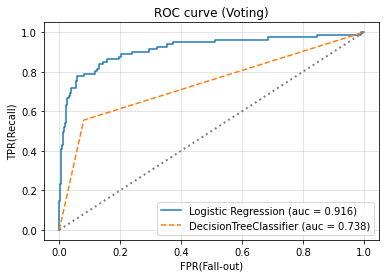

In [28]:
models = [logistic_r, decision_tree]
labels = ['Logistic Regression', 'DecisionTreeClassifier']
linestyles = ['-', '--']
colors = ['orange', 'blue']

for model, label, color, ls in zip(models, labels, colors, linestyles):
    model.fit(X_train_over, y_train_over)
    pred_proba = model.predict_proba(X_val)[:,1]

    fpr, tpr, thresholds = roc_curve(y_val, pred_proba)
    roc = pd.DataFrame({
        'FPR(Fall-out)': fpr,
        'TPR(Recall)': tpr,
        'Threshold': thresholds
    })
    plt.plot(fpr, tpr, linestyle = ls, label = '%s (auc = %0.3f)' %(label, auc(fpr, tpr)))

plt.legend(loc = 'lower right')
plt.grid(alpha = 0.4)
plt.title('ROC curve (Voting)')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.plot([0, 1], [0, 1], linestyle = ':', color = 'grey', linewidth = 2)

plt.show()

In [29]:
#def predict_label(clf, data):
#    pred_prob = clf.predict_proba(data)[:,1]
#    return pred_prob

def get_clf_eval(y_true, y_pred, y_pred_proba):
    print('Confusion Matrix :\n', confusion_matrix(y_true, y_pred)) # "오차행렬"
    print('Accuracy : ', accuracy_score(y_true, y_pred))
    print('Precision : ', precision_score(y_true, y_pred))
    print('Recall : ', recall_score(y_true, y_pred))
    print('f1 score : ', f1_score(y_true, y_pred))
    print('roc_auc score : ', roc_auc_score(y_true, y_pred_proba))

def get_model_eval(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val) # 예측 확률값
    y_pred_proba = model.predict_proba(X_val)[:,1] # 1의 확률 array
    get_clf_eval(y_val, y_pred, y_pred_proba)

In [30]:
get_model_eval(logistic_r, X_train_over, X_val, y_train_over, y_val)
print('--------------------------------------------------------------')
get_model_eval(decision_tree, X_train_over, X_val, y_train_over, y_val)

Confusion Matrix :
 [[498 287]
 [  5  76]]
Accuracy :  0.6628175519630485
Precision :  0.209366391184573
Recall :  0.9382716049382716
f1 score :  0.34234234234234234
roc_auc score :  0.9160965636549501
--------------------------------------------------------------
Confusion Matrix :
 [[722  63]
 [ 36  45]]
Accuracy :  0.8856812933025404
Precision :  0.4166666666666667
Recall :  0.5555555555555556
f1 score :  0.4761904761904762
roc_auc score :  0.737650389242746


### **RandomForest**

In [31]:
models = [decision_tree, randomforestclf]
labels = ['DecisionTreeClassifier', 'RandomForestClassifier']

for model, label in zip(models, labels):
    scores = cross_val_score(
        estimator = model, 
        X = X_train_over, y = y_train_over, 
        cv = 10, 
        scoring = 'roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]" %(scores.mean(), scores.std(), label))

# ROC AUC: 0.925 (+/- 0.027) [DecisionTreeClassifier]
# ROC AUC: 0.990 (+/- 0.009) [RandomForestClassifier]

ROC AUC: 0.926 (+/- 0.032) [DecisionTreeClassifier]
ROC AUC: 0.990 (+/- 0.007) [RandomForestClassifier]


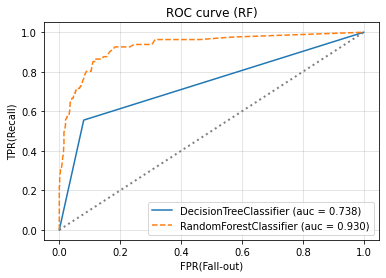

In [32]:
models = [decision_tree, randomforestclf]
labels = ['DecisionTreeClassifier', 'RandomForestClassifier']
linestyles = ['-', '--']
colors = ['orange', 'blue']

for model, label, color, ls in zip(models, labels, colors, linestyles):
    model.fit(X_train_over, y_train_over)
    pred_proba = model.predict_proba(X_val)[:,1]

    fpr, tpr, thresholds = roc_curve(y_val, pred_proba)
    roc = pd.DataFrame({
        'FPR(Fall-out)': fpr,
        'TPR(Recall)': tpr,
        'Threshold': thresholds
    })
    plt.plot(fpr, tpr, linestyle = ls, label = '%s (auc = %0.3f)' %(label, auc(fpr, tpr)))

plt.legend(loc = 'lower right')
plt.grid(alpha = 0.4)
plt.title('ROC curve (RF)')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.plot([0, 1], [0, 1], linestyle = ':', color = 'grey', linewidth = 2)

plt.show()



In [33]:
get_model_eval(decision_tree, X_train_over, X_val, y_train_over, y_val)

Confusion Matrix :
 [[722  63]
 [ 36  45]]
Accuracy :  0.8856812933025404
Precision :  0.4166666666666667
Recall :  0.5555555555555556
f1 score :  0.4761904761904762
roc_auc score :  0.737650389242746


In [34]:
get_model_eval(randomforestclf, X_train_over, X_val, y_train_over, y_val)

Confusion Matrix :
 [[730  55]
 [ 22  59]]
Accuracy :  0.9110854503464203
Precision :  0.5175438596491229
Recall :  0.7283950617283951
f1 score :  0.6051282051282051
roc_auc score :  0.9303058897538727


### **Boosting**

In [35]:
models = [xgboost, adaboost]
labels = ['XGBClassifier', 'AdaBoostClassifier']

for model, label in zip(models, labels):
    scores = cross_val_score(
        estimator = model, 
        X = X_train_over, y = y_train_over, 
        cv = 10, 
        scoring = 'roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]" %(scores.mean(), scores.std(), label))

# ROC AUC: 0.992 (+/- 0.015) [XGBClassifier]
# ROC AUC: 0.925 (+/- 0.027) [AdaBoostClassifier]

ROC AUC: 0.993 (+/- 0.013) [XGBClassifier]
ROC AUC: 0.928 (+/- 0.031) [AdaBoostClassifier]


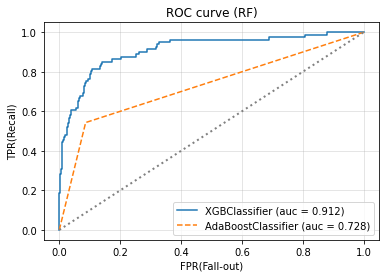

In [36]:
models = [xgboost, adaboost]
labels = ['XGBClassifier', 'AdaBoostClassifier']
linestyles = ['-', '--']
colors = ['orange', 'blue']

for model, label, color, ls in zip(models, labels, colors, linestyles):
    model.fit(X_train_over, y_train_over)
    pred_proba = model.predict_proba(X_val)[:,1]

    fpr, tpr, thresholds = roc_curve(y_val, pred_proba)
    roc = pd.DataFrame({
        'FPR(Fall-out)': fpr,
        'TPR(Recall)': tpr,
        'Threshold': thresholds
    })
    plt.plot(fpr, tpr, linestyle = ls, label = '%s (auc = %0.3f)' %(label, auc(fpr, tpr)))

plt.legend(loc = 'lower right')
plt.grid(alpha = 0.4)
plt.title('ROC curve (RF)')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.plot([0, 1], [0, 1], linestyle = ':', color = 'grey', linewidth = 2)

plt.show()

In [37]:
get_model_eval(xgboost, X_train_over, X_val, y_train_over, y_val)

Confusion Matrix :
 [[756  29]
 [ 34  47]]
Accuracy :  0.9272517321016166
Precision :  0.618421052631579
Recall :  0.5802469135802469
f1 score :  0.5987261146496815
roc_auc score :  0.9116772823779191


In [38]:
get_model_eval(adaboost, X_train_over, X_val, y_train_over, y_val)

Confusion Matrix :
 [[717  68]
 [ 37  44]]
Accuracy :  0.8787528868360277
Precision :  0.39285714285714285
Recall :  0.5432098765432098
f1 score :  0.45595854922279794
roc_auc score :  0.7282928363607769


### 모델 선택

In [39]:
!pip install beautifultable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers = ['Model Name', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score']
table.append_row(['Logistic Regression', '0.2094', '0.9383', '0.3423', '0.9161'])
table.append_row(['Decision Tree', '0.4167', '0.5556', '0.4762', '0.7377'])
table.append_row(['RandomForest', '0.5175', '0.7284', '0.6051', '0.9303'])
table.append_row(['XGBoost', '0.6184', '0.5803', '0.5987', '0.9117'])
table.append_row(['AdaBoost', '0.3929', '0.5432', '0.4560', '0.7283'])
print(table)

#Precision :  0.209366391184573
#Recall :  0.9382716049382716
#f1 score :  0.34234234234234234
#roc_auc score :  0.9160965636549501
#--------------------------------------------------
#Precision :  0.4166666666666667
#Recall :  0.5555555555555556
#f1 score :  0.4761904761904762
#roc_auc score :  0.737650389242746
#--------------------------------------------------
#Precision :  0.5175438596491229
#Recall :  0.7283950617283951
#f1 score :  0.6051282051282051
#roc_auc score :  0.9303058897538727
#--------------------------------------------------
#Precision :  0.618421052631579
#Recall :  0.5802469135802469
#f1 score :  0.5987261146496815
#roc_auc score :  0.9116772823779191
#--------------------------------------------------
#Precision :  0.39285714285714285
#Recall :  0.5432098765432098
#f1 score :  0.45595854922279794
#roc_auc score :  0.7282928363607769

+---------------------+-----------+--------+----------+---------------+
|     Model Name      | Precision | Recall | F1 Score | ROC AUC Score |
+---------------------+-----------+--------+----------+---------------+
| Logistic Regression |   0.209   | 0.938  |  0.342   |     0.916     |
+---------------------+-----------+--------+----------+---------------+
|    Decision Tree    |   0.417   | 0.556  |  0.476   |     0.738     |
+---------------------+-----------+--------+----------+---------------+
|    RandomForest     |   0.517   | 0.728  |  0.605   |     0.93      |
+---------------------+-----------+--------+----------+---------------+
|       XGBoost       |   0.618   |  0.58  |  0.599   |     0.912     |
+---------------------+-----------+--------+----------+---------------+
|      AdaBoost       |   0.393   | 0.543  |  0.456   |     0.728     |
+---------------------+-----------+--------+----------+---------------+


/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


- **모델 선택**: f1-score과 AUC score 모두 고려했을 때  **RandomForestClassifier** 모델의 성능이 가장 높게 나타남.

# 최적화

## 하이퍼파라미터 튜닝

### RandomForestClassifier()

In [42]:
# 1) RandomizedSearchCV를 이용, 최적 파라미터 찾기
randomforest = RandomForestClassifier()

dists2 = {    
        'n_estimators' : randint(50, 500),
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_leaf': randint(1, 10),
        'max_features': uniform(0, 1) 
        }
    
randomforest_cv = RandomizedSearchCV(
    randomforest, 
    param_distributions = dists2, 
    n_iter = 50,
    cv = 3, 
    scoring = 'roc_auc',
    random_state = 42,
    verbose = 1, 
    n_jobs = -1, 
    )

randomforest_cv.fit(X_train_over, y_train_over)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe918f66750>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe918f66550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe918f663d0>},
                   random_state=42, scoring='roc_auc', verbose=1)

In [43]:
print("Best parameters: ", randomforest_cv.best_params_)
print("roc_auc_score: ", randomforest_cv.best_score_)

Best parameters:  {'max_depth': 15, 'max_features': 0.30087830981676966, 'min_samples_leaf': 1, 'n_estimators': 489}
roc_auc_score:  0.9879954837207999


In [44]:
# 2) 최적 파라미터로 모델 학습 및 성능 확인
random_forest = RandomForestClassifier(max_depth = 15, max_features = 0.30087830981676966, min_samples_leaf = 1, n_estimators = 489)
random_forest.fit(X_train_over, y_train_over)

RandomForestClassifier(max_depth=15, max_features=0.30087830981676966,
                       n_estimators=489)

In [45]:
# get_model_eval
get_model_eval(random_forest, X_train_over, X_val, y_train_over, y_val)

Confusion Matrix :
 [[726  59]
 [ 19  62]]
Accuracy :  0.9099307159353349
Precision :  0.512396694214876
Recall :  0.7654320987654321
f1 score :  0.6138613861386137
roc_auc score :  0.9287253283006998


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


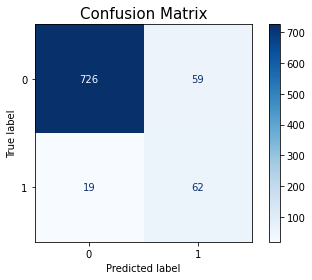

In [46]:
# 3) 모델 성능 확인 시각화 (Confusion Matrix, ROC Curve)
# 3)-(1) Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots() 
pcm = plot_confusion_matrix(random_forest, X_val, y_val, cmap = plt.cm.Blues, ax = ax)
plt.title('Confusion Matrix', fontsize = 15)
plt.show()

Text(0, 0.5, 'TPR(Recall)')

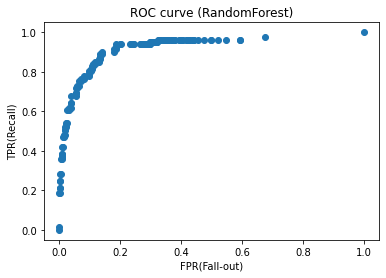

In [47]:
# 3) 모델 성능 확인 시각화 (Confusion Matrix, ROC Curve)
# 3)-(2) ROC curve
pred_proba_rf = random_forest.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, pred_proba_rf)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr,
    'TPR(Recall)': tpr,
    'Threshold': thresholds
})
plt.scatter(fpr, tpr)
plt.title('ROC curve (RandomForest)')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

# 최종모델 재학습
"만약 여러분이 hold-out 교차검증(훈련/검증/테스트 세트로 한 번만 나누어 실험)을 수행한 경우에는, (훈련+검증) 데이터셋에서 최적화된 하이퍼파라미터로 최종 모델을 재학습(refit) 해야 합니다."

In [48]:
# hold-out CV: 테스트 데이터셋에서 최적화된 하이퍼파라미터로 최종 모델 재학습
random_forest = RandomForestClassifier(max_depth = 15, max_features = 0.30087830981676966, min_samples_leaf = 1, n_estimators = 489)
random_forest.fit(X_train_over, y_train_over)

RandomForestClassifier(max_depth=15, max_features=0.30087830981676966,
                       n_estimators=489)

In [49]:
# get_model_eval
y_test = test[target] # target = 'PotentialFraud'
get_model_eval(random_forest, X_train_over, X_test, y_train_over, y_test)

# y_pred = random_forest.predict(X_test)
# y_pred_proba = random_forest.predict_proba(X_test)[:,1] # 테스트 데이터 예측 1의 확률
# get_clf_eval(y_val, y_pred, y_pred_proba) # y_test, y_pred, y_pred_proba 를 바탕으로 다양한 평가지표 산출(유틸리티 함수)

#def get_model_eval(model, X_train, X_val, y_train, y_val):
#    model.fit(X_train, y_train)
#    y_pred = model.predict(X_val) # 예측 확률값
#    y_pred_proba = model.predict_proba(X_val)[:,1] # 1의 확률 array
#    get_clf_eval(y_val, y_pred, y_pred_proba)

#def get_clf_eval(y_true, y_pred, y_pred_proba):
#    print('Confusion Matrix :\n', confusion_matrix(y_true, y_pred)) # "오차행렬"
#    print('Accuracy : ', accuracy_score(y_true, y_pred))
#    print('Precision : ', precision_score(y_true, y_pred))
#    print('Recall : ', recall_score(y_true, y_pred))
#    print('f1 score : ', f1_score(y_true, y_pred))
#    print('roc_auc score : ', roc_auc_score(y_true, y_pred_proba))

Confusion Matrix :
 [[899  82]
 [ 32  69]]
Accuracy :  0.8946395563770795
Precision :  0.45695364238410596
Recall :  0.6831683168316832
f1 score :  0.5476190476190477
roc_auc score :  0.9242993106650117


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


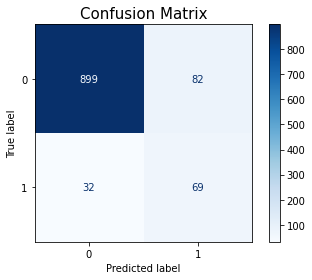

In [50]:
# 3) 테스트 데이터에서 성능 확인 시각화 (Confusion Matrix, ROC Curve)
# 3)-(1) Confusion Matrix
fig, ax = plt.subplots() 
pcm = plot_confusion_matrix(random_forest, X_test, y_test, cmap = plt.cm.Blues, ax = ax)
plt.title('Confusion Matrix', fontsize = 15)
plt.show()

Test AUC =  0.9242993106650117


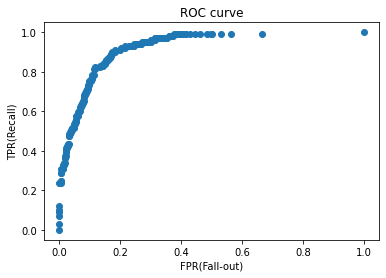

In [51]:
# 3) 테스트 데이터에서 성능 확인 시각화 (Confusion Matrix, ROC Curve)
# 3)-(2) ROC curve

# y_pred = model.predict_proba(X_train)[:,1] # predict the probability of train data
pred_proba_test = random_forest.predict_proba(X_test)[:,1]
# pred_proba_xgb = xgboost.predict_proba(X_val)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, pred_proba_test)

roc = pd.DataFrame({
    'FPR(Fall-out)': test_fpr,
    'TPR(Recall)': test_tpr,
    'Threshold': test_thresholds
})
plt.scatter(test_fpr, test_tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

# calculate auc for train and test
test_auc = auc(test_fpr, test_tpr)
print("Test AUC = ", test_auc)

- **결론**: 최적화한 파라미터 재학습 후 테스트 데이터에서의 성능 확인 결과 ROC AUC score 는 0.928 > 0.924 로 소폭 감소 확인.

# 최종모델 설명
- 여러 수치적 지표 및 permutation importance, pdp, shap 등을 활용해 최종모델 설명 (시각화는 설명이 가장 중요)
- 1.에서 제시한 가설 해결

- 교차검증이나 hold-out 기법을 사용해 학습 성능/일반화 성능 구분하여 제시
- 1.에서 제시한 가설 해결

Q1. 학습한 모델이 기준모델보다 성능이 잘 나왔나? 그렇지 않다면 이유는?<br>
Q2. 모델 성능 개선을 위해 어떤 방법을 적용했나? 그 방법을 선택한 이유는?<br>
Q3. 최종 모델과 일반화 성능에 관해 설명<br>

## 특성 중요도

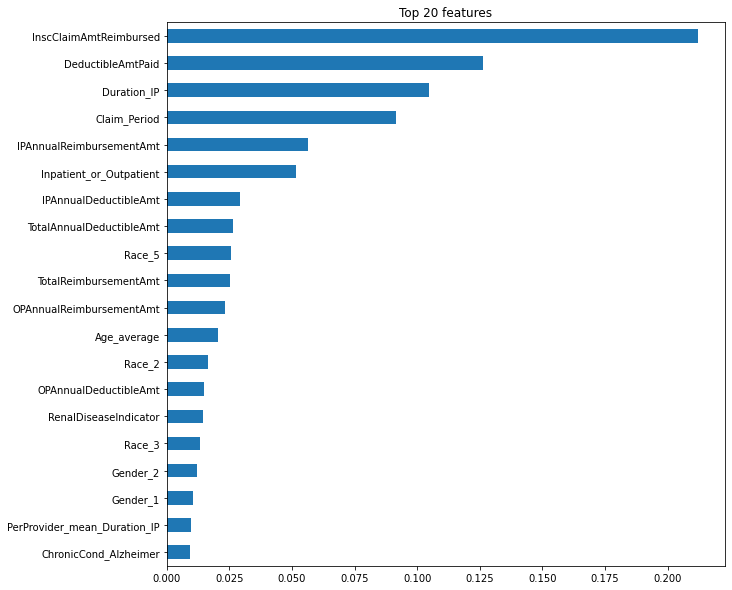

In [52]:
# random_forest = RandomForestClassifier(max_depth = 20, max_features = 0.2692613453110473, min_samples_leaf = 2, n_estimators = 236)
importances = pd.Series(random_forest.feature_importances_, X_train_over.columns)

%matplotlib inline
# import matplotlib.pyplot as plt

n = 20
plt.figure(figsize = (10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [53]:
importances.sort_values(ascending = False)

InscClaimAmtReimbursed                       0.212243
DeductibleAmtPaid                            0.126388
Duration_IP                                  0.104847
Claim_Period                                 0.091389
IPAnnualReimbursementAmt                     0.056548
Inpatient_or_Outpatient                      0.051469
IPAnnualDeductibleAmt                        0.029202
TotalAnnualDeductibleAmt                     0.026598
Race_5                                       0.025744
TotalReimbursementAmt                        0.025233
OPAnnualReimbursementAmt                     0.023308
Age_average                                  0.020328
Race_2                                       0.016437
OPAnnualDeductibleAmt                        0.014882
RenalDiseaseIndicator                        0.014626
Race_3                                       0.013145
Gender_2                                     0.012136
Gender_1                                     0.010519
PerProvider_mean_Duration_IP

In [54]:
# 카디널리티 확인 함수 (in 렉처노트)
# 특성 중요도가 높게 나온 ( )는 유의해서 봐야한다. ()개 카테고리로 구성되어 있는데 다른 특성과 비교하여 상대적으로 high-cardinality 특성 - 트리 구성 중 분기에 이용될 확률이 높아 과적합 위험

In [55]:
len(X_train['InscClaimAmtReimbursed'].value_counts())

2541

In [56]:
len(X_train['DeductibleAmtPaid'].value_counts())

905

In [57]:
len(X_train['Duration_IP'].value_counts())

363

In [58]:
len(X_train['Claim_Period'].value_counts())

368

In [59]:
len(X_train['Inpatient_or_Outpatient'].value_counts())

132

## 순열 중요도

In [60]:
pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 6.9 MB/s 
     |████████████████████████████████| 133 kB 51.5 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=fe455d7a7dc50e457d61c15a9cb4bdeb981c348dc2fb8d79f99e79117a75c461
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

In [61]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    random_forest,
    scoring = 'roc_auc', 
    n_iter = 5
    )

permuter.fit(X_test, y_test)
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()


OPAnnualReimbursementAmt                    -0.002677
PerProvider_mean_IPAnnualReimbursementAmt   -0.002137
PerProvider_mean_OPAnnualReimbursementAmt   -0.001385
OPAnnualDeductibleAmt                       -0.001256
PerProvider_mean_InscClaimAmtReimbursed     -0.001225
PerProvider_mean_Patient_Age                -0.001040
Gender_2                                    -0.000962
Race_5                                      -0.000582
PerProvider_count_ClaimID                   -0.000560
ChronicCond_Alzheimer                       -0.000432
is_dead                                     -0.000339
Age_average                                 -0.000166
IPAnnualDeductibleAmt                       -0.000143
TotalAnnualDeductibleAmt                     0.000001
PerProvider_mean_Patient_Risk_Score          0.000004
Claimed_extra                                0.000143
PerProvider_count_Claims                     0.000182
PerProvider_mean_OPAnnualDeductibleAmt       0.000219
PerProvider_mean_IPAnnualDed

In [62]:
eli5.show_weights(
    permuter, 
    top = None, 
    feature_names = feature_names
    )

# Weight	Feature
# 0.0294 ± 0.0064	InscClaimAmtReimbursed
# 0.0236 ± 0.0115	Duration_IP
# 0.0200 ± 0.0103	Claim_Period
# 0.0198 ± 0.0049	PerProvider_mean_Claim_Period
# 0.0168 ± 0.0049	Inpatient_or_Outpatient
# 0.0167 ± 0.0081	DeductibleAmtPaid
# 0.0159 ± 0.0096	PerProvider_mean_Duration_IP

Weight,Feature
0.0294 ± 0.0064,InscClaimAmtReimbursed
0.0236 ± 0.0115,Duration_IP
0.0200 ± 0.0103,Claim_Period
0.0198 ± 0.0049,PerProvider_mean_Claim_Period
0.0168 ± 0.0049,Inpatient_or_Outpatient
0.0167 ± 0.0081,DeductibleAmtPaid
0.0159 ± 0.0096,PerProvider_mean_Duration_IP
0.0084 ± 0.0039,IPAnnualReimbursementAmt
0.0043 ± 0.0028,PerProvider_mean_DeductibleAmtPaid
0.0035 ± 0.0064,RenalDiseaseIndicator


## PDP

### 1 PDP

In [ ]:
# pip install wheel

In [ ]:
# !pip3 install --user matplotlib

In [63]:
!pip install pdpbox
# !pip3 install pdpbox --user 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 1.2 MB/s 
     |████████████████████████████████| 13.1 MB 24.6 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=5ecb632d34aa706bd977115caa4addc7eda5a0ae8f131afc567225213c487b15
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


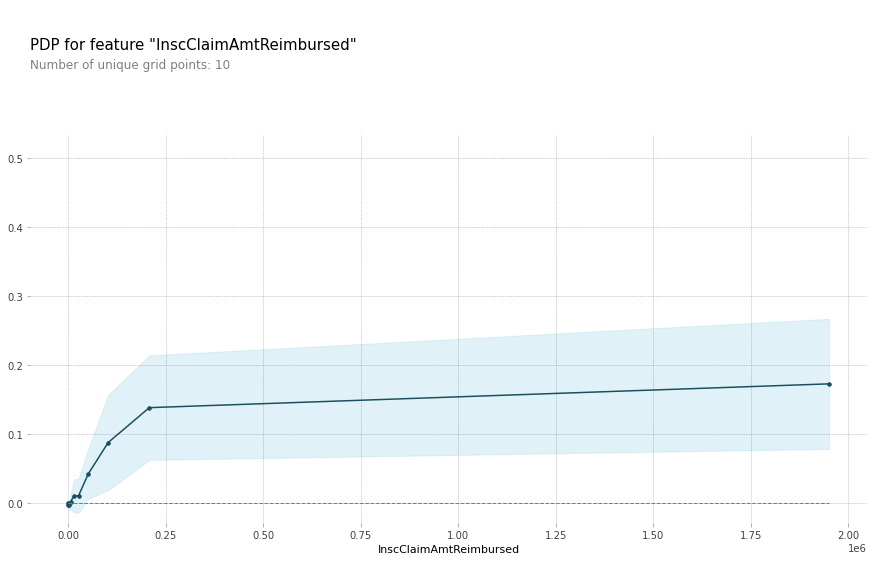

In [65]:
# 1. InscClaimAmtReimbursed (1 pdp)
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'InscClaimAmtReimbursed' # 수치형
isolated = pdp_isolate(
    model = random_forest,
    dataset = X_test,
    model_features = X_test.columns,
    feature = feature
)
pdp_plot(isolated, feature_name = feature);

(<Figure size 1080x684 with 3 Axes>,
 {'pdp_ax': {'_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe8b87e6610>,
   '_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe8b8831190>},
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe8b88c7850>})

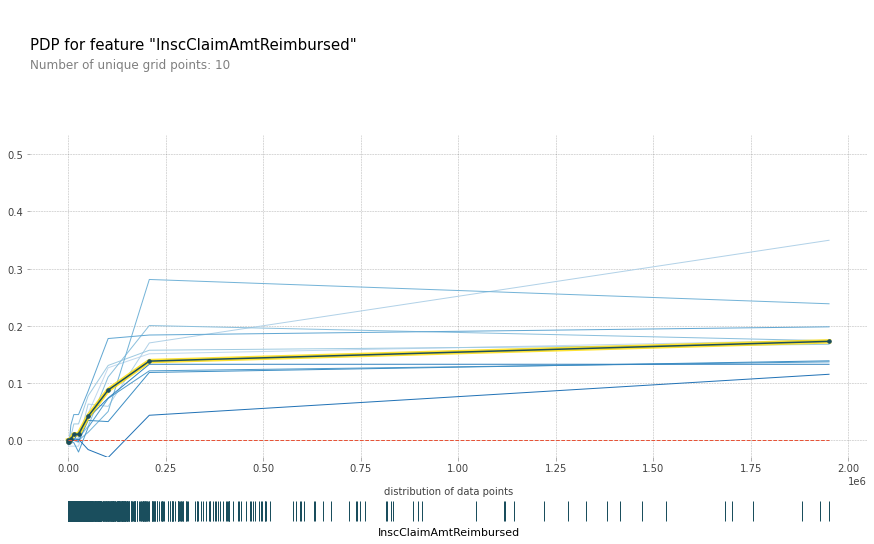

In [66]:
# ICE curve와 함께 그려보기 - ICE의 평균이 PDP
pdp_plot(isolated,
         feature_name = feature, 
         plot_lines = True, # ICE Plots
         frac_to_plot = 10, # or 10 (# 10000 val set * 0.001),
         plot_pts_dist = True
         )     

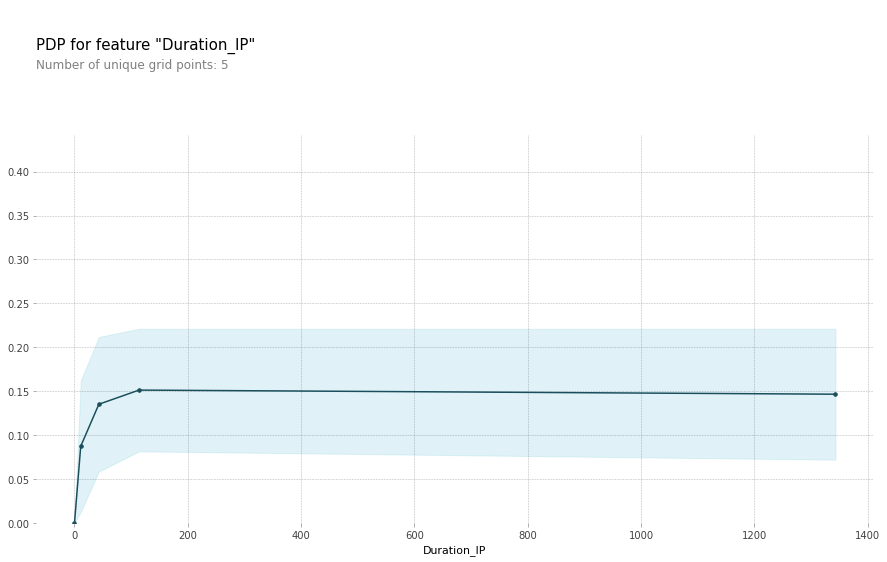

In [67]:
# 2. Duration_IP (1 pdp)
from pdpbox.pdp import pdp_isolate, pdp_plot
# Duration_IP
feature = 'Duration_IP' # 수치형
isolated = pdp_isolate(
    model = random_forest,
    dataset = X_test,
    model_features = X_test.columns,
    feature = feature
)
pdp_plot(isolated, feature_name = feature);

(<Figure size 1080x684 with 3 Axes>,
 {'pdp_ax': {'_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe8b6d54890>,
   '_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe8b6d9f410>},
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe8b6de37d0>})

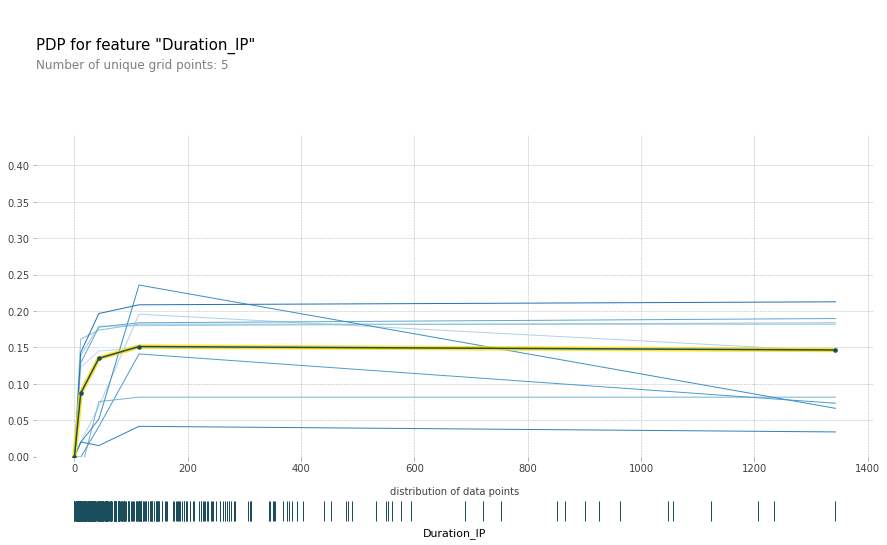

In [68]:
# ICE curve와 함께 그려보기 - ICE의 평균이 PDP
pdp_plot(isolated,
         feature_name = feature, 
         plot_lines = True, # ICE Plots
         frac_to_plot = 10, # or 10 (# 10000 val set * 0.001),
         plot_pts_dist = True
         )

### 2 PDP

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe8b6c029d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fe8b6ba7850>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


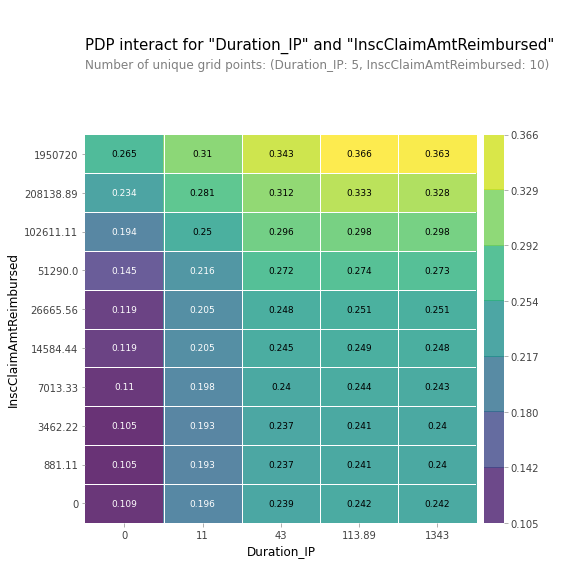

In [70]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Duration_IP', 'InscClaimAmtReimbursed'] # 수치형

interaction = pdp_interact(
    model = random_forest,
    dataset = X_test,
    model_features = X_test.columns,
    features = features
)

pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features)

## Shapley value

### 분류기 학습 등

In [71]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 8.1 MB/s 


In [72]:
y_train.value_counts(normalize = True)

0    0.906412
1    0.093588
Name: PotentialFraud, dtype: float64

In [73]:
ratio = 0.09/0.91 # 클래스 비율 0 / 1 (약 10 / 90)
ratio

0.0989010989010989

In [74]:
eval_set1 = [(X_train, y_train), 
            (X_val, y_val)]
eval_set2 = [(X_train_over, y_train_over), 
            (X_val, y_val)]

In [75]:
# XGBoost 분류기 학습1 (v)
# random_forest = RandomForestClassifier(max_depth = None, max_features = 0.5393644114450201, min_samples_leaf = 1, n_estimators = 473)
# random_forest.fit(X_train_over, y_train_over, eval_set = eval_set)

from xgboost import XGBClassifier
model1 = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model1.fit(X_train, y_train, eval_set = eval_set1, eval_metric = 'auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.6795	validation_1-auc:0.724503
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.773199	validation_1-auc:0.817937
[2]	validation_0-auc:0.810117	validation_1-auc:0.827105
[3]	validation_0-auc:0.810195	validation_1-auc:0.827105
[4]	validation_0-auc:0.816885	validation_1-auc:0.832956
[5]	validation_0-auc:0.871653	validation_1-auc:0.892632
[6]	validation_0-auc:0.871862	validation_1-auc:0.893481
[7]	validation_0-auc:0.87174	validation_1-auc:0.893583
[8]	validation_0-auc:0.871625	validation_1-auc:0.893678
[9]	validation_0-auc:0.871566	validation_1-auc:0.893678
[10]	validation_0-auc:0.871745	validation_1-auc:0.893843
[11]	validation_0-auc:0.871759	validation_1-auc:0.893843
[12]	validation_0-auc:0.871904	validation_1-auc:0.893615
[13]	validation_0-auc:0.872238	validation_1-auc:0.893906
[14]	validation_0-auc:0.872419	validation_1-auc:0.893764
[

XGBClassifier(n_estimators=1000, n_jobs=-1, scale_pos_weight=0.0989010989010989,
              verbosity=0)

In [76]:
# XGBoost 분류기 학습2
# random_forest = RandomForestClassifier(max_depth = None, max_features = 0.5393644114450201, min_samples_leaf = 1, n_estimators = 473)
# random_forest.fit(X_train_over, y_train_over, eval_set = eval_set)

model2 = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight = 1) # 0.5/0.5
model2.fit(X_train_over, y_train_over, eval_set = eval_set2, eval_metric = 'auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.938538	validation_1-auc:0.927011
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.944683	validation_1-auc:0.935166
[2]	validation_0-auc:0.94757	validation_1-auc:0.93791
[3]	validation_0-auc:0.951204	validation_1-auc:0.938358
[4]	validation_0-auc:0.951474	validation_1-auc:0.937745
[5]	validation_0-auc:0.95172	validation_1-auc:0.937902
[6]	validation_0-auc:0.952095	validation_1-auc:0.937407
[7]	validation_0-auc:0.954858	validation_1-auc:0.937163
[8]	validation_0-auc:0.955147	validation_1-auc:0.936392
[9]	validation_0-auc:0.955385	validation_1-auc:0.937029
[10]	validation_0-auc:0.955615	validation_1-auc:0.936667
[11]	validation_0-auc:0.956045	validation_1-auc:0.936738
[12]	validation_0-auc:0.957699	validation_1-auc:0.93592
[13]	validation_0-auc:0.958034	validation_1-auc:0.936565
Stopping. Best iteration:
[3]	validation_0-auc:0.951204	val

XGBClassifier(n_estimators=1000, n_jobs=-1, verbosity=0)

In [77]:
# from sklearn.metrics import roc_auc_score 1
class_index = 1
y_pred_proba1 = model1.predict_proba(X_test)[:, class_index]
print(f'Test AUC for class "{model1.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba1)) # 범위는 0~1, 수치는 높을수록 좋다

Test AUC for class "1":
0.9351288339843159


In [78]:
# from sklearn.metrics import roc_auc_score 2
class_index = 1
y_pred_proba2 = model2.predict_proba(X_test)[:, class_index]
print(f'Test AUC for class (Oversampling) "{model2.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba2)) # 범위는 0~1, 수치는 높을수록 좋다

Test AUC for class (Oversampling) "1":
0.9286896579566213


In [79]:
# Confusion Matrix 확인1
# from sklearn.metrics import classification_report
y_test_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_test_pred1))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       981
           1       1.00      0.20      0.33       101

    accuracy                           0.93      1082
   macro avg       0.96      0.60      0.65      1082
weighted avg       0.93      0.93      0.90      1082



In [80]:
# Confusion Matrix 확인2
# from sklearn.metrics import classification_report
y_test_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_test_pred2))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       981
           1       0.39      0.86      0.54       101

    accuracy                           0.86      1082
   macro avg       0.69      0.86      0.73      1082
weighted avg       0.93      0.86      0.88      1082



In [81]:
y_pred_proba2

array([0.33812392, 0.36578006, 0.33812392, ..., 0.33812392, 0.33812392,
       0.43588668], dtype=float32)

In [82]:
# 예측값 VS. 실제값 비교
# 'Provider'?
provider_count = X_test['PerProvider_count_Claims']
df_p = pd.DataFrame({
    'PerProvider_count_Claims': provider_count, 
    'pred_proba': y_pred_proba2, # 예측확률 
    'status_group': y_test # 실제값
}) # df_p.shape:(1082, 3)

df_p = df_p.merge(X_test[['PerProvider_count_Claims', 'InscClaimAmtReimbursed', 'PerProvider_mean_Claim_Period', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 'Claim_Period', 'Duration_IP', 'PerProvider_mean_Duration_IP']], 
                  how='left') # df_p.shape: (16026, 11) ???????
			

In [83]:
# 선택하여 열 이름 변경하기: df.rename(columns={'Before':'After'})
df_p.rename(columns={'PerProvider_count_Claims':'provider_count'})

,provider_count,pred_proba,status_group,InscClaimAmtReimbursed,PerProvider_mean_Claim_Period,DeductibleAmtPaid,RenalDiseaseIndicator,Claim_Period,Duration_IP,PerProvider_mean_Duration_IP
0,1,0.338124,0,10,0.000000,0.0,0,0.0,0.0,0.000000
1,1,0.338124,0,30,0.000000,0.0,0,0.0,0.0,0.000000
2,1,0.338124,0,400,0.000000,0.0,0,0.0,0.0,0.000000
3,1,0.338124,0,50,0.000000,0.0,0,0.0,0.0,0.000000
4,1,0.338124,0,60,0.000000,0.0,0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
14197,11,0.338124,0,48970,0.040571,7476.0,3,54.0,54.0,0.040571
14198,11,0.338124,0,5930,0.000000,0.0,1,0.0,0.0,0.000000
14199,11,0.338124,0,4380,0.000000,40.0,3,0.0,0.0,0.000000
14200,11,0.338124,0,2020,0.000000,0.0,5,0.0,0.0,0.000000


In [84]:
fraud = df_p['status_group'] == 1
not_fraud = ~fraud
right = (fraud) == (df_p['pred_proba'] > 0.50)
wrong = ~right

### fraud & right

In [85]:
# TP: fraud & right
df_p[fraud&right].sample(n=10, random_state = 1).sort_values(by='pred_proba')

,PerProvider_count_Claims,pred_proba,status_group,InscClaimAmtReimbursed,PerProvider_mean_Claim_Period,DeductibleAmtPaid,RenalDiseaseIndicator,Claim_Period,Duration_IP,PerProvider_mean_Duration_IP
6620,14,0.557219,1,78170,0.015671,10680.0,2,43.0,43.0,0.015671
6619,14,0.557219,1,3080,0.000000,0.0,4,0.0,0.0,0.000000
10464,11,0.557219,1,4280,0.000000,0.0,0,0.0,0.0,0.000000
5891,18,0.565792,1,54160,0.002915,3274.0,3,17.0,17.0,0.002915
8290,49,0.582304,1,163340,0.000671,10680.0,4,79.0,79.0,0.000671
11638,43,0.582304,1,171030,0.001031,16080.0,12,82.0,82.0,0.001031
9633,29,0.626838,1,9830,0.000287,10.0,6,7.0,7.0,0.000287
9088,52,0.628937,1,13170,0.000000,200.0,9,0.0,0.0,0.000000
5709,122,0.654051,1,222200,0.000062,17898.0,39,113.0,113.0,0.000062
513,456,0.654051,1,1045640,0.000008,116814.0,105,721.0,721.0,0.000008


In [186]:
# 테스트셋 301번 데이터 .shape: (1, 37)
row = X_test.iloc[[513]]
row 

,InscClaimAmtReimbursed,DeductibleAmtPaid,Duration_IP,Claim_Period,Claimed_extra,Inpatient_or_Outpatient,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,...,PerProvider_mean_Patient_Risk_Score,PerProvider_count_ClaimID,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5,PerProvider_count_Claims,Age_average
245,16010,3204.0,15.0,15.0,0.0,3,4,252,252,5,...,0.009178,0.047619,8.0,13.0,16.0,5.0,0.0,0.0,21,74.0


In [ ]:
# shap 그래프로 예측 설명
import xgboost
import shap

explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value, 
    shap_values = shap_values, 
    features = row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [ ]:
# 예측을 shap 그래프를 통해 설명하는 함수
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

print('fraud 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

In [167]:
def explain(row_number):
    positive_class = 1
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.iloc[[row_number]]
    # row_processed = processor.transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = model1.predict(row)[0] # row_processed
    pred_proba = model1.predict_proba(row)[0, positive_class_index] # row_processed
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'이 보험 청구건에 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row) # row_processed

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [ ]:
explain(37)

### not_fraud & right

In [147]:
# TN: not_fraud & right
df_p[not_fraud & right].sample(n=10).sort_values(by='pred_proba')

,PerProvider_count_Claims,pred_proba,status_group,InscClaimAmtReimbursed,PerProvider_mean_Claim_Period,DeductibleAmtPaid,RenalDiseaseIndicator,Claim_Period,Duration_IP,PerProvider_mean_Duration_IP
1848,21,0.338124,0,5180,0.000000,0.0,7,0.0,0.0,0.000000
2699,6,0.338124,0,1310,0.000000,0.0,0,0.0,0.0,0.000000
13726,14,0.338124,0,124940,0.036808,12816.0,4,101.0,101.0,0.036808
1191,4,0.338124,0,90,0.000000,0.0,0,0.0,0.0,0.000000
13430,10,0.338124,0,120000,0.095000,9612.0,3,95.0,95.0,0.095000
484,3,0.338124,0,1320,0.000000,0.0,3,0.0,0.0,0.000000
5776,16,0.338124,0,4280,0.000000,90.0,2,0.0,0.0,0.000000
10244,21,0.338124,0,5550,0.000000,0.0,5,0.0,0.0,0.000000
11241,2,0.338124,0,110,0.000000,0.0,0,0.0,0.0,0.000000
11605,4,0.338124,0,47000,0.281250,4272.0,1,18.0,18.0,0.281250


In [162]:
# 예시. 테스트셋 800번 데이터
pre = model1.predict(X_test.iloc[[800]])[0] # row_processed
pre_pro = model1.predict_proba(X_test.iloc[[800]])[0, 1]
pre, pre_pro # 97%가 됨

(0, 0.028548392)

In [163]:
explain(800)

이 보험 청구건에 대한 예측결과는 0 으로, 확률은 97% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. InscClaimAmtReimbursed : 88140.0
2. DeductibleAmtPaid : 11858.0
3. Claim_Period : 69.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. Duration_IP : 69.0
2. Inpatient_or_Outpatient : 11.0
3. RenalDiseaseIndicator : 7.0


### not_fraud & wrong

In [151]:
# FP: not_fraud & wrong
df_p[not_fraud & wrong].sample(n=10).sort_values(by='pred_proba')

,PerProvider_count_Claims,pred_proba,status_group,InscClaimAmtReimbursed,PerProvider_mean_Claim_Period,DeductibleAmtPaid,RenalDiseaseIndicator,Claim_Period,Duration_IP,PerProvider_mean_Duration_IP
9807,38,0.519122,0,8240,0.000000,70.0,3,0.0,0.0,0.000000
13621,53,0.519122,0,185920,0.000416,8584.0,10,62.0,62.0,0.000416
11690,34,0.557219,0,145050,0.003104,20292.0,9,122.0,122.0,0.003104
7321,15,0.557219,0,12500,0.000889,1068.0,3,3.0,3.0,0.000889
11649,15,0.557219,0,6080,0.000000,50.0,7,0.0,0.0,0.000000
3258,53,0.565792,0,43920,0.000208,5860.0,7,31.0,31.0,0.000208
6483,720,0.573638,0,197060,0.000000,1750.0,117,0.0,0.0,0.000000
3308,18,0.583494,0,4750,0.000000,50.0,6,0.0,0.0,0.000000
10163,151,0.609747,0,169960,0.000035,13176.0,28,121.0,121.0,0.000035
5997,280,0.639857,0,128900,0.000000,890.0,58,0.0,0.0,0.000000


In [152]:
X_test.iloc[[794]]

,InscClaimAmtReimbursed,DeductibleAmtPaid,Duration_IP,Claim_Period,Claimed_extra,Inpatient_or_Outpatient,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,...,PerProvider_mean_Patient_Risk_Score,PerProvider_count_ClaimID,Gender_1,Gender_2,Race_1,Race_2,Race_3,Race_5,PerProvider_count_Claims,Age_average
867,880,0.0,0.0,0.0,0.0,0,1,96,96,5,...,0.082031,0.125,2.0,6.0,8.0,0.0,0.0,0.0,8,82.0


In [ ]:
# 예시. 테스트셋 10번 데이터
pre = model2.predict(X_test.iloc[[741]])[0] # row_processed
pre_pro = model2.predict_proba(X_test.iloc[[741]])[0, 1]
pre, pre_pro # %가 됨

In [ ]:
explain(735)

### fraud & wrong

In [ ]:
# FN: fraud & wrong
df_p[fraud & wrong].sample(n=5).sort_values(by='pred_proba')

,PerProvider_count_Claims,pred_proba,status_group,InscClaimAmtReimbursed,PerProvider_mean_Claim_Period,DeductibleAmtPaid,RenalDiseaseIndicator,Claim_Period,Duration_IP,PerProvider_mean_Duration_IP
14802,393,0.197713,1,107830,0.0,1290.0,84,0.0,0.0,0.0
2666,18,0.353643,1,2860,0.0,160.0,0,0.0,0.0,0.0
14563,3,0.418351,1,260,0.0,0.0,0,0.0,0.0,0.0
14572,3,0.418351,1,100,0.0,0.0,0,0.0,0.0,0.0
4,20,0.438610,1,4770,0.0,60.0,3,0.0,0.0,0.0


In [ ]:
# 예시. 테스트셋 18번 데이터
#pre = model2.predict(X_test.iloc[[1027]])[0] # row_processed
#pre_pro = model2.predict_proba(X_test.iloc[[1027]])[0, 1]
#pre, pre_pro # 59%가 됨

(1, 0.5796597)

In [ ]:
#explain(186)

### shap.force_plot 시도
> 참고. https://zzinnam.tistory.com/entry/SHAP-value%EC%97%90-%EB%8C%80%ED%95%9C-%EA%B0%84%EB%8B%A8%ED%95%9C-%EC%86%8C%EA%B0%9Cwith-Python


In [161]:
shap.initjs()
explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(X_test)
shap.force_plot(explainer1.expected_value, shap_values1, feature_names=X_test.columns)

# Exception: In v0.20 force_plot now requires the base value as the first parameter! 
# Try shap.force_plot(explainer.expected_value, shap_values) 
# or for multi-output models try shap.force_plot(explainer.expected_value[0], shap_values[0]).

# 감사합니다! (Colab 2/2)